In [1]:
import torch
import torchaudio
from torchaudio import transforms

import matplotlib.pyplot as plt

import librosa

from pathlib import Path

from load import readAudio, readAnnotations
from convert_enst import ENST_MAPPING

In [2]:
def plot_data(data: torch.Tensor, label: torch.Tensor) -> None:
    fig, ax = plt.subplots(2)

    ax[0].set_title("Data (400 frames, 84 bins, 1 channel)")
    ax[0].imshow(data.T)
    ax[0].set_xlabel("Frames (hop size: 10ms)")
    ax[0].set_ylabel("Frequency bins")
    ax[0].invert_yaxis()

    ax[1].set_title("Target (400 frames, 5 classes)")
    ax[1].imshow(label.T.round(), aspect=10, interpolation="nearest")
    ax[1].set_xlabel("Frames (hop size: 10ms)")
    ax[1].set_ylabel("Classes")
    ax[1].set_yticks([0, 1, 2, 3, 4], ("BD", "SD", "TT", "HH", "CY+RD"))
    ax[1].invert_yaxis()

    fig.tight_layout()
    plt.show()

In [3]:
path = Path("../data/ENST-drums-public/drummer_1").resolve()
filename = "108_minus-one_rock-60s_sticks"

audio_path = (path / "audio" / "wet_mix" / filename).with_suffix(".wav")
accompaniment_path = (path / "audio" / "accompaniment" / filename).with_suffix(".wav")
annotation_path = (path / "annotation" / filename).with_suffix(".txt")

torch.Size([3351599])
tensor([-0.0006, -0.0008, -0.0007,  ...,  0.0000,  0.0000,  0.0000])
tensor([-0.0010, -0.0008, -0.0009,  ...,  0.0000,  0.0000,  0.0000])


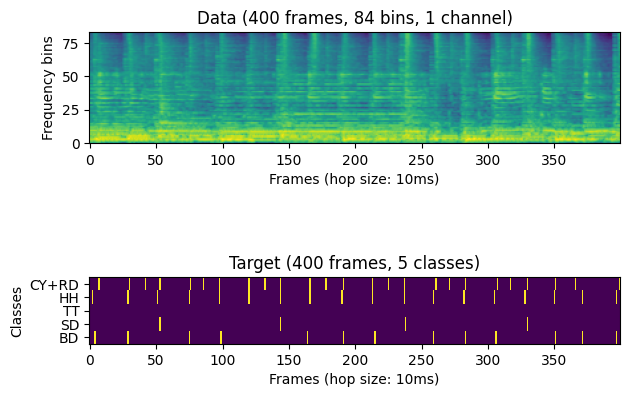

In [17]:
spectrogram = readAudio(audio_path, accompaniment_path)
timesteps = spectrogram.shape[0]
label = readAnnotations(annotation_path, ENST_MAPPING, timesteps, 5)

partitions = timesteps // 400

spectrograms = torch.stack(spectrogram.tensor_split(partitions, dim=0))
labels = torch.stack(label.tensor_split(partitions, dim=0))

plot_data(spectrograms[15], labels[15])

torch.Size([7209, 84])
torch.Size([7600, 5])


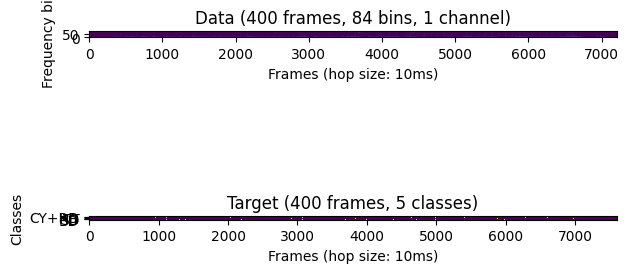

In [5]:
def plot_waveform(waveform: torch.tensor, sr: int = 22050, title: str = "") -> None:
    """Plot a given waveform"""
    librosa.display.waveshow(waveform.numpy(), sr=sr, alpha=0.5)
    plt.ylabel("Relative intensity")
    plt.title(title)

def plot_spectrogram(spectrogram: torch.tensor, hop_length: int, sr: int = 22050, title: str = "", y_axis: str = "linear", color_unit: str = "", ylabel: str = "") -> None:
    """Plot a spectrogram"""
    librosa.display.specshow(spectrogram.numpy(), sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    plt.colorbar(format="%+2.f " + color_unit)

    plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)

waveform, sr = torchaudio.load(audio_path)
waveform = waveform.mean(dim=0)
spectrogram = transforms.MelSpectrogram(sample_rate=sr, n_fft=2048, win_length=2048, hop_length=441, n_mels=84, power=1)(waveform).T
print(spectrogram.shape)
print(labels.shape)
#plot_spectrogram(spectrogram, hop_length=2048, y_axis="linear")

plot_data(spectrogram, labels)
